In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Obtaining and cleaning data

In [131]:
df = pd.read_csv("entries.csv")
topics = pd.read_csv("topics.csv")

In [132]:
print(len(df))
print(df.head())
print(topics.head())

17067
   id                            andrew_id_hash semester           entry_time  \
0   1  5660915b416b110d3125eddaf15d004c09f2dcf9      S17  2017-01-18 16:30:42   
1   2  7a3ff1726a9e59878e74b78b612e705ba388f35c      S17  2017-01-18 16:30:47   
2   3  33573dcedddbc5924f4fc0c16db8b901fd1c8286      S17  2017-01-18 16:31:00   
3   4  2291bad572687d3d7e8fb1c4c4ad21c0b83c1e67      S17  2017-01-18 16:31:09   
4   5  9a08eb5de601714dce83c7c7e5040509349f512c      S17  2017-01-18 16:32:51   

             help_time            exit_time  wait_estimate  topic_id  ta_id  
0  2017-01-18 16:31:36  2017-01-18 16:31:39            NaN       5.0      8  
1  2017-01-18 16:31:44  2017-01-18 16:34:53            NaN       4.0     22  
2  2017-01-18 16:32:12  2017-01-18 16:33:05            NaN       4.0     17  
3  2017-01-18 16:32:28  2017-01-18 16:38:52            NaN       4.0     16  
4  2017-01-18 16:33:15  2017-01-18 16:39:42            0.0       1.0     17  
   id             name       out_date  

In [133]:
df2 = df.drop(['wait_estimate', 'ta_id', 'id', 'semester'], axis=1)
df2 = df2.dropna(axis=0, how='any')
print(len(df2))

16062


In [134]:
topics = topics.drop(['out_date', 'due_date', 'semester'], axis=1)
print(topics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
id      120 non-null int64
name    120 non-null object
dtypes: int64(1), object(1)
memory usage: 2.0+ KB
None


In [135]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16062 entries, 0 to 17066
Data columns (total 5 columns):
andrew_id_hash    16062 non-null object
entry_time        16062 non-null object
help_time         16062 non-null object
exit_time         16062 non-null object
topic_id          16062 non-null float64
dtypes: float64(1), object(4)
memory usage: 752.9+ KB
None


In [136]:
df2['entry_time'] = pd.to_datetime(df2['entry_time'])
df2['help_time'] = pd.to_datetime(df2['help_time'])
df2['exit_time'] = pd.to_datetime(df2['exit_time'])
df2['topic_id'] = df2['topic_id'].astype(int)

In [137]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16062 entries, 0 to 17066
Data columns (total 5 columns):
andrew_id_hash    16062 non-null object
entry_time        16062 non-null datetime64[ns]
help_time         16062 non-null datetime64[ns]
exit_time         16062 non-null datetime64[ns]
topic_id          16062 non-null int64
dtypes: datetime64[ns](3), int64(1), object(1)
memory usage: 752.9+ KB
None


In [138]:
df2['WT'] = (df2['help_time'] - df2['entry_time']).astype('timedelta64[s]').astype(int)
df2['HT'] = (df2['exit_time'] - df2['help_time']).astype('timedelta64[s]').astype(int)

In [139]:
df3 = df2[['andrew_id_hash', 'WT', 'HT', 'topic_id']]
print(df3.info())
print(df3.head())
print(topics.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16062 entries, 0 to 17066
Data columns (total 4 columns):
andrew_id_hash    16062 non-null object
WT                16062 non-null int64
HT                16062 non-null int64
topic_id          16062 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.2+ MB
None
                             andrew_id_hash  WT   HT  topic_id
0  5660915b416b110d3125eddaf15d004c09f2dcf9  54    3         5
1  7a3ff1726a9e59878e74b78b612e705ba388f35c  57  189         4
2  33573dcedddbc5924f4fc0c16db8b901fd1c8286  72   53         4
3  2291bad572687d3d7e8fb1c4c4ad21c0b83c1e67  79  384         4
4  9a08eb5de601714dce83c7c7e5040509349f512c  24  387         1
   id             name
0   1    setup (Linux)
1   2         written1
2   3         scavhunt
3   4      setup (Mac)
4   5  setup (Windows)


In [140]:
df3 = df3.where(df3['HT'] > 30).dropna()
df3 = df3.where(df3['HT'] < 2700).dropna()
print(len(df3))

15533


### Merging with the topic list

In [141]:
df4 = df3.merge(topics, left_on='topic_id', right_on='id')
df4 = df4.drop(['topic_id', 'id'], axis=1)
print(df4.head())
print(len(df4))

                             andrew_id_hash     WT     HT         name
0  7a3ff1726a9e59878e74b78b612e705ba388f35c   57.0  189.0  setup (Mac)
1  33573dcedddbc5924f4fc0c16db8b901fd1c8286   72.0   53.0  setup (Mac)
2  2291bad572687d3d7e8fb1c4c4ad21c0b83c1e67   79.0  384.0  setup (Mac)
3  9bf345f89e209ba0c0cf5ffb6a450669fdc96910  116.0   61.0  setup (Mac)
4  8098b7df9506a418f44cbf339a82d59f8c4b0391  126.0  145.0  setup (Mac)
15533


In [142]:
topiclist = df4['name'].unique()
print(topiclist)

['setup (Mac)' 'setup (Linux)' 'setup (Windows)' 'written1' 'scavhunt'
 'written2' 'pixels' 'written3' 'images' 'written4' 'doslingos'
 'images style' 'written5' 'midterm1' 'written6' 'clac-exp' 'written7'
 'tbuf' 'exp style' 'written8' 'bloom' 'written9' 'ropes' 'written10'
 'queues' 'written11' 'lightsout' 'written12' 'c0vm' 'written13' 'speller'
 'exam1' 'clac' 'exam3' 'editor-check' 'editor' 'midterm2' 'strbuf'
 'huffman' 'final']


In [143]:
topicmap = {}
for topic in topiclist:
    if (topic[:7] == 'written'):
        topicmap[topic] = 'written'
    elif (topic[-5:] == 'style'):
        topicmap[topic] = 'style'
    elif (topic == 'midterm1' or topic == 'midterm2' or topic == 'final' or topic == 'exam1' or topic == 'exam2' or topic == 'exam3'):
        topicmap[topic] = 'exam'
    else:
        topicmap[topic] = topic

In [144]:
df4['new_id'] = df4['name'].apply(lambda x : topicmap[x])
df5 = df4.drop(['name'], axis=1)
print(df5['new_id'].unique())
print(df5.head())

['setup (Mac)' 'setup (Linux)' 'setup (Windows)' 'written' 'scavhunt'
 'pixels' 'images' 'doslingos' 'style' 'exam' 'clac-exp' 'tbuf' 'bloom'
 'ropes' 'queues' 'lightsout' 'c0vm' 'speller' 'clac' 'editor-check'
 'editor' 'strbuf' 'huffman']
                             andrew_id_hash     WT     HT       new_id
0  7a3ff1726a9e59878e74b78b612e705ba388f35c   57.0  189.0  setup (Mac)
1  33573dcedddbc5924f4fc0c16db8b901fd1c8286   72.0   53.0  setup (Mac)
2  2291bad572687d3d7e8fb1c4c4ad21c0b83c1e67   79.0  384.0  setup (Mac)
3  9bf345f89e209ba0c0cf5ffb6a450669fdc96910  116.0   61.0  setup (Mac)
4  8098b7df9506a418f44cbf339a82d59f8c4b0391  126.0  145.0  setup (Mac)


In [145]:
print(df5['new_id'].value_counts())

written            3945
c0vm               1758
ropes              1024
lightsout          1022
style               709
queues              701
images              697
bloom               651
tbuf                570
pixels              555
clac-exp            504
doslingos           493
exam                428
huffman             420
strbuf              352
clac                342
speller             321
scavhunt            290
editor              236
setup (Mac)         230
editor-check        154
setup (Windows)     120
setup (Linux)        11
Name: new_id, dtype: int64


In [176]:
print(len(df5['andrew_id_hash'].value_counts().where(df5['andrew_id_hash'].value_counts() > 0).dropna()))
print(len(df5['andrew_id_hash'].value_counts().where(df5['andrew_id_hash'].value_counts() > 1).dropna()))
print(len(df5['andrew_id_hash'].value_counts().where(df5['andrew_id_hash'].value_counts() > 20).dropna()))
print(df5['andrew_id_hash'].value_counts().where(df5['andrew_id_hash'].value_counts() > 10).dropna())

1003
757
209
21cb1f9adbacb7cf4bfb15085966652648310c05    297.0
9552e74bcf06aaccfc4ac863c57ac0c8040d7640    233.0
40ad830a60baf6e374a0806135957ca5daa3f7ca    199.0
b3410512fdbf24a6ab4ee26c44d72942f29d7054    191.0
1e71f0a29beb17e4924590a0bba9170aefc0e346    176.0
ee9df52b8820e414b470c173f87d1f9191947508    171.0
b94f8abee597235b3295f127dcce8027bd6a3510    162.0
5660915b416b110d3125eddaf15d004c09f2dcf9    161.0
fc66dfab82fdad061547aa40cdf9c33329d35928    151.0
3e236fb0e2c1fbd7140c029ca6ba44a831775256    142.0
e95edbc398975eb64a9b9d396b445669adbbb586    139.0
9641cfd54915b40ee1a83fc5e7caa0e75fa7ecae    125.0
fcd7f19d1b99ab5e1897984c08887df30eb0449b    120.0
9af33cc369b031fb335f04660b1207915496e40f    120.0
773f5f725a8f8c491d73539ad76c752d9457993b    118.0
00cb4d194d9203f201f0608575e0cab8e78aaf78    115.0
0b4c1ae362a828b876ac9ac88082161a57b3750c    107.0
4e91b67af0b399db887b7b186c6437e92190db66    106.0
a34e6dcd71b7cbd85572e920a11dd05fc0223b8c    106.0
e740b05973b3001388429e166c9bf301ea43d

### Visualization

(array([  91.,  401.,  497.,  422.,  390.,  306.,  280.,  231.,  206.,
         166.,  127.,  118.,   92.,   84.,   80.,   68.,   49.,   36.,
          37.,   35.]),
 array([    0.,    50.,   100.,   150.,   200.,   250.,   300.,   350.,
          400.,   450.,   500.,   550.,   600.,   650.,   700.,   750.,
          800.,   850.,   900.,   950.,  1000.]),
 <a list of 20 Patch objects>)

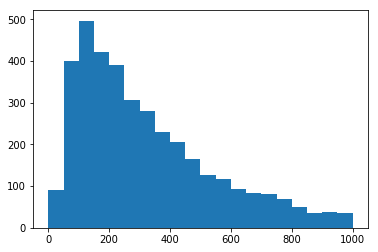

In [157]:
writtens = df5['HT'].where(df5['new_id'] == 'written').dropna()
plt.hist(writtens, bins=20, range=(0,1000))

(array([  16.,  105.,  109.,  132.,  141.,  124.,   94.,  115.,   98.,
          74.,   72.,   78.,   47.,   55.,   55.,   46.,   48.,   36.,
          31.,   30.]),
 array([    0.,    50.,   100.,   150.,   200.,   250.,   300.,   350.,
          400.,   450.,   500.,   550.,   600.,   650.,   700.,   750.,
          800.,   850.,   900.,   950.,  1000.]),
 <a list of 20 Patch objects>)

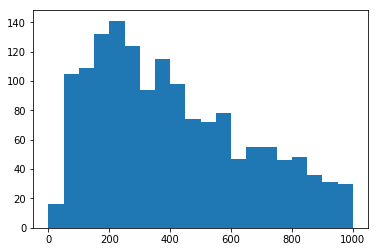

In [156]:
c0vm = df5['HT'].where(df5['new_id'] == 'c0vm').dropna()
plt.hist(c0vm, bins=20, range=(0,1000))

(array([  5.,  12.,   8.,   9.,  13.,  10.,  16.,   9.,  12.,  13.,  13.,
         15.,  12.,  11.,   6.,   9.,  10.,  14.,  12.,   7.,  11.,   5.,
          4.,   4.,   8.,   7.,   9.,   5.,  12.,   7.,   5.,   7.,  11.,
          4.,   3.,   3.,   3.,   5.,   5.,   6.,   3.,   4.,   4.,   2.,
          2.,   5.,   2.,   5.,   2.,   2.,   1.,   3.,   2.,   3.,   1.,
          2.,   3.,   1.,   1.,   2.,   0.,   2.,   3.,   1.,   1.,   1.,
          3.,   1.,   1.,   2.,   1.,   1.,   1.,   0.,   2.,   2.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,
          1.]),
 array([   40.  ,    65.77,    91.54,   117.31,   143.08,   168.85,
          194.62,   220.39,   246.16,   271.93,   297.7 ,   323.47,
          349.24,   375.01,   400.78,   426.55,   452.32,   478.09,
          503.86,   529.63,   555.4 ,   581.17,   606.94,   632.71,
          658.48,   684.25,   710.02,   735.79

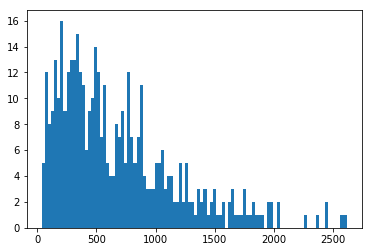

In [160]:
huffman = df5['HT'].where(df5['new_id'] == 'huffman').dropna()
plt.hist(huffman, bins=100)

(array([ 30.,  38.,  44.,  34.,  40.,  25.,  26.,  10.,  12.,   5.,   8.,
          7.,   5.,   4.,   2.,   4.,   1.,   0.,   1.,   1.]),
 array([   39.  ,   167.35,   295.7 ,   424.05,   552.4 ,   680.75,
          809.1 ,   937.45,  1065.8 ,  1194.15,  1322.5 ,  1450.85,
         1579.2 ,  1707.55,  1835.9 ,  1964.25,  2092.6 ,  2220.95,
         2349.3 ,  2477.65,  2606.  ]),
 <a list of 20 Patch objects>)

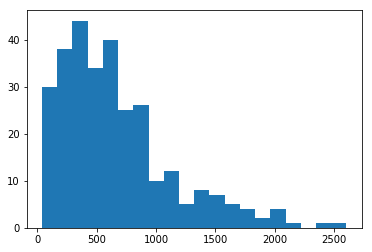

In [178]:
helpthispersonpls297 = df5['HT'].where(df5['andrew_id_hash'] == '21cb1f9adbacb7cf4bfb15085966652648310c05').dropna()
plt.hist(helpthispersonpls297, bins=20)

(array([ 18.,   8.,  16.,  12.,   9.,   8.,   3.,   4.,   1.,   0.,   7.,
          1.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,   1.]),
 array([   58. ,   172.3,   286.6,   400.9,   515.2,   629.5,   743.8,
          858.1,   972.4,  1086.7,  1201. ,  1315.3,  1429.6,  1543.9,
         1658.2,  1772.5,  1886.8,  2001.1,  2115.4,  2229.7,  2344. ]),
 <a list of 20 Patch objects>)

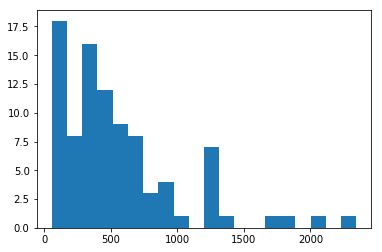

In [179]:
helpthispersonpls91 = df5['HT'].where(df5['andrew_id_hash'] == '39336da3a02c026b0c12605951c433d870e4e021').dropna()
plt.hist(helpthispersonpls91, bins=20)